<a href="https://colab.research.google.com/github/flavio185/bootcamp-ia/blob/main/BootCamp_ex3_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
import pandas as pd
import ssl


ssl._create_default_https_context = ssl._create_unverified_context
url = 'https://raw.githubusercontent.com/flavio185/bootcamp-ia/main/solicitacoescredito.csv'
dataset = pd.read_csv(url)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.25,0.00,2015-12-10T00:00:00,0,0.00,...,12.00,0.00,2003.00,Acima de 17 anos,90000.00,False,True,1.00,43200.00,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.00,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.62,0.00,2019-11-27T00:00:00,0,0.00,...,7.00,0.00,2014.00,De 6 a 10 anos,20000.00,False,True,1.00,4320.00,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.00,NaN,2017-02-13T17:20:27,0,0.00,...,12.00,0.00,2013.00,De 6 a 10 anos,30000.00,False,True,0.00,5920.00,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.45,0.00,2010-07-13T00:00:00,20,1486.95,...,9.00,40680051.00,2002.00,Acima de 17 anos,75000.00,False,False,1.00,89000.00,2020-02-04T15:06:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,9041,Leah Williams,Georgia Booth,YKGZ02907098931653,149,0.31,0.00,2006-04-26T00:00:00,59,599964.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN
8969,9042,Mr. Jordan Stevens,Miss Ellie Kelly,UCBM91111020900951,23,0.33,0.00,2016-08-03T00:00:00,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.96,NaN,NaN
8970,9043,Mr. Barry Wells,Danielle Hudson,CLDB61185288622179,3,0.38,0.00,2018-10-25T00:00:00,4,2933.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN
8971,9044,Keith Jones,Steven Kennedy-Jones,BRJP37453437154592,11,0.42,0.00,2011-08-10T00:00:00,31,559679.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN


##PRE PROCESS

In [ ]:
ds=dataset[[
'cnpjSemTraco',
'maiorAtraso',
'margemBrutaAcumulada',
'prazoMedioRecebimentoVendas',
'titulosEmAberto',
'valorSolicitado',
'diferencaPercentualRisco',
'percentualRisco',
'faturamentoBruto',
'margemBruta',
'custos',
'capitalSocial',
'restricoes',
'valorAprovado',
]]

In [ ]:
#Pega somente linhas em que o emprestimo foi aprovado e temos unm valor
ds = ds.loc[ds['valorAprovado']>0]

#Remove algumas linhas restantes com valores nulos.
ds = ds[ds['faturamentoBruto'].notna()]

#OnehotEncode restricoes
ds = pd.get_dummies(ds,prefix=['restricoes'], columns = ['restricoes'], drop_first=True)

#Tora restricoes da ultima posicao.
cols = ds.columns.tolist()
cols = cols[-1:] + cols[:-1]
ds = ds[cols]

In [ ]:
#Deixo uma entrada por CLiente. Escolhendo a entrada com o maior emprestimo aprovado para o cliente.
df = pd.DataFrame(columns = ds.columns)
duplicados = ds.loc[ds.cnpjSemTraco.duplicated()]['cnpjSemTraco']
for i in set(duplicados):
  maior_valor = ds.loc[ds['cnpjSemTraco']==i]['valorAprovado'].max()
  row = ds.loc[ (ds['cnpjSemTraco']==i ) & (ds['valorAprovado'] == maior_valor ) ][:][:1]
  df = pd.concat([df, row])

ds = ds.drop_duplicates(subset=['cnpjSemTraco'], keep=False, inplace=True)

ds = pd.concat([df, ds])

#Removo Cnpj
ds.drop('cnpjSemTraco', axis=1, inplace=True)

#Reset index
ds.reset_index(drop=True, inplace=True)

#Corrige data types
ds['restricoes_True'] = ds['restricoes_True'].astype(int)
ds['maiorAtraso'] = ds['maiorAtraso'].astype(int)
ds['prazoMedioRecebimentoVendas'] = ds['prazoMedioRecebimentoVendas'].astype(int)

#
ds.dtypes

restricoes_True                  int64
maiorAtraso                      int64
margemBrutaAcumulada           float64
prazoMedioRecebimentoVendas      int64
titulosEmAberto                float64
valorSolicitado                float64
diferencaPercentualRisco       float64
percentualRisco                float64
faturamentoBruto               float64
margemBruta                    float64
custos                         float64
capitalSocial                  float64
valorAprovado                  float64
dtype: object

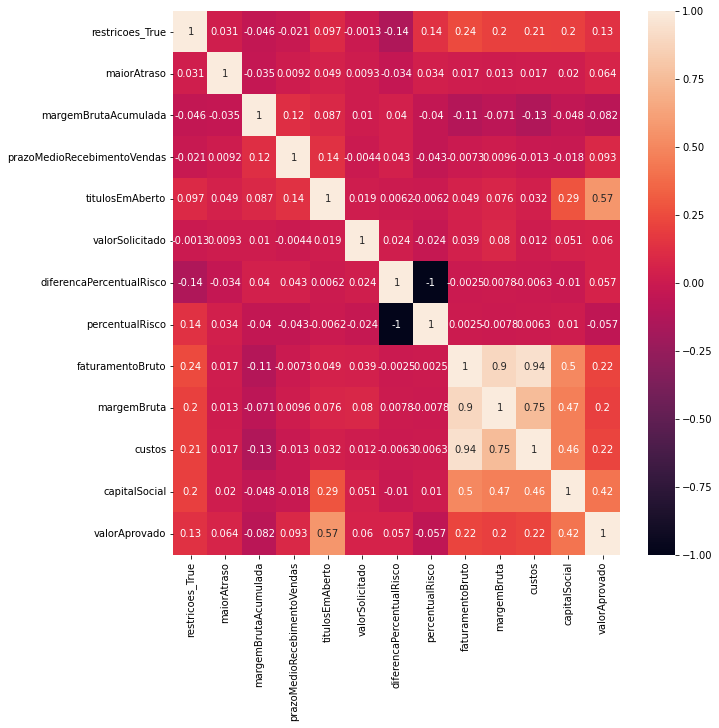

In [ ]:
import math
from matplotlib import pyplot as plt
import seaborn as sb


corr = ds.corr(method='pearson')
plt.figure(figsize=(10, 10))
sb.heatmap(corr, annot = True)

In [ ]:
#'diferencaPercentualRisco','margemBruta', 'custos'
# Exclusão das caracteristicas com alta correlação
ds.drop(['diferencaPercentualRisco','margemBruta', 'custos'], axis = 1, inplace=True)
ds.info()
ds.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   restricoes_True              1713 non-null   int64  
 1   maiorAtraso                  1713 non-null   int64  
 2   margemBrutaAcumulada         1713 non-null   float64
 3   prazoMedioRecebimentoVendas  1713 non-null   int64  
 4   titulosEmAberto              1713 non-null   float64
 5   valorSolicitado              1713 non-null   float64
 6   percentualRisco              1713 non-null   float64
 7   faturamentoBruto             1713 non-null   float64
 8   capitalSocial                1713 non-null   float64
 9   valorAprovado                1713 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 134.0 KB


,margemBrutaAcumulada,titulosEmAberto,valorSolicitado,diferencaPercentualRisco,percentualRisco,faturamentoBruto,margemBruta,custos,capitalSocial,valorAprovado
count,1713.00,1713.00,1713.00,1713.00,1713.00,1713.00,1713.00,1713.00,1713.00,1713.00
mean,0.38,40551.58,572648.52,0.74,0.26,56465866.21,19221466.73,29087782.42,8760708.07,191115.19
std,0.19,193918.56,14505721.48,0.13,0.13,348459698.08,140974441.53,223710602.94,66373266.95,579932.57
min,0.00,0.00,100.00,0.34,0.00,0.00,-21684628.00,-49267738.00,0.00,10.00
25%,0.31,0.00,30000.00,0.64,0.14,1428301.00,0.00,0.00,50000.00,20000.00
50%,0.42,0.00,50000.00,0.75,0.25,3725867.00,0.00,0.00,100000.00,40000.00
75%,0.52,10700.18,110000.00,0.86,0.36,16022528.00,3487173.00,3959206.00,430000.00,100000.00
max,1.00,3938589.70,600000000.00,1.00,0.66,6426115000.00,3366842514.00,4393536000.00,979957432.00,10700000.00


In [ ]:
ds.loc[ds['valorAprovado']>5050000.00].describe()

,restricoes_True,maiorAtraso,margemBrutaAcumulada,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,percentualRisco,faturamentoBruto,capitalSocial,valorAprovado
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,0.40,32.60,0.36,7.40,1304740.02,6990000.00,0.35,97418995.20,594477594.00,6990000.00
std,0.55,35.32,0.33,7.80,1614117.44,2108435.44,0.17,133434919.39,527936280.04,2108435.44
min,0.00,8.00,0.00,0.00,0.00,5500000.00,0.14,0.00,2000000.00,5500000.00
25%,0.00,12.00,0.00,0.00,0.00,6000000.00,0.25,0.00,30515674.00,6000000.00
50%,0.00,19.00,0.55,6.00,1093374.04,6200000.00,0.28,0.00,979957432.00,6200000.00
75%,1.00,30.00,0.62,15.00,1491736.37,6550000.00,0.50,239016696.00,979957432.00,6550000.00
max,1.00,94.00,0.63,16.00,3938589.70,10700000.00,0.55,248078280.00,979957432.00,10700000.00


##Classificação

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
X = ds.iloc[:,0:-1].values
y = ds.iloc[:,-1].values

In [ ]:
#Normalização do Conjunto
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)



In [ ]:
qtd_features = len(X[0,:]) #X.shape[1]
qtd_features

9

In [ ]:
print('train_X shape:', X_train.shape)
print('train_Y shape:', y_train.shape)

train_X shape: (1199, 9)
train_Y shape: (1199,)




```
# Isto está formatado como código
```



###Regressão

In [ ]:
import lightgbm as lgb


In [ ]:
model = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=5215, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
model.fit(X_train, y_train)

LGBMRegressor(random_state=5215, silent='warn')

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

65524.147786331145
57384278070.9615
239550.1577352048


In [ ]:
dfresult = pd.DataFrame({
        "Emprestimo Original": y_test,
        "Emprestimo Predito": y_pred
    })
dfresult

,Emprestimo Original,Emprestimo Predito
0,30000.00,28390.45
1,30000.00,28346.07
2,10000.00,9384.87
3,6000000.00,3363720.97
4,20000.00,26632.40
...,...,...
509,820000.00,837072.78
510,10000.00,7453.46
511,15000.00,18031.70
512,100000.00,80369.20


In [ ]:
classificador_acuracia = model.score(X_test, y_test)
classificador_acuracia

0.8283018839501898

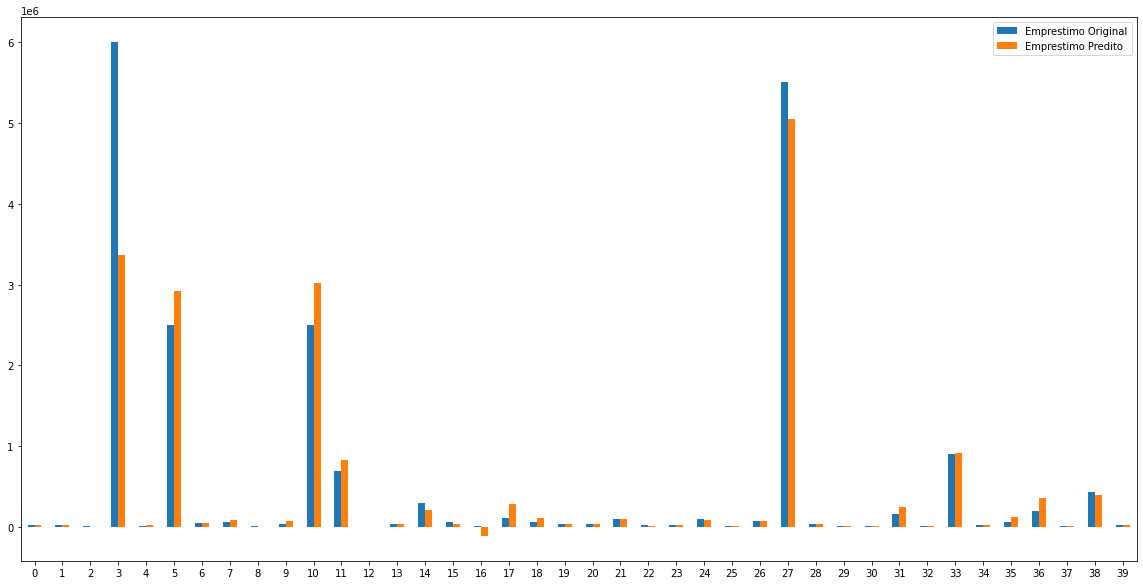

In [ ]:
dfresult.head(40).plot.bar(rot=0, figsize = (20,10))